### Download SPADE and Semantic Segmentation on MIT ADE20K dataset

In [1]:
# !git clone https://github.com/NVlabs/SPADE.git
# !git clone https://github.com/CSAILVision/semantic-segmentation-pytorch.git

# cd SPADE/models/networks/
# git clone https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
# cp -rf Synchronized-BatchNorm-PyTorch/sync_batchnorm .

In [2]:
import sys
import os
import pathlib
import shutil

import torch
import torch.nn as nn
import torchvision.transforms

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


sys.path += ["SPADE", "semantic-segmentation-pytorch"]

All pretrained models can be found at: http://sceneparsing.csail.mit.edu/model/pytorch

Download pretrained segmentation model

In [3]:
# !wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth /ckpt
# !wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth /ckpt

### Configure segmentation model

In [4]:
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

class SegmentationModel(SegmentationModule):
    def __init__(self, colors_path: str):
        encoder = ModelBuilder.build_encoder(
            arch="resnet50dilated",
            fc_dim=2048,
            weights="ckpt/encoder_epoch_20.pth"
        )
        decoder = ModelBuilder.build_decoder(
            arch="ppm_deepsup",
            fc_dim=2048,
            num_class=150,
            weights="ckpt/decoder_epoch_20.pth",
            use_softmax=True
        )
        crit = nn.NLLLoss(ignore_index=-1)
        
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        self.colors = scipy.io.loadmat(colors_path)["colors"]
        
        super().__init__(encoder, decoder, crit)
        
    def visualize_result(self, img: Image, pred, index=None):
        # filter prediction class if requested
        img = np.array(img)
        
        if index is not None:
            pred = pred.copy()
            pred[pred != index] = -1
            print(f"{names[index+1]}:")

        # colorize prediction
        pred_color = colorEncode(pred, self.colors).astype(np.uint8)

        # aggregate images and save
        im_vis = np.concatenate((img, pred_color), axis=1)
        display(Image.fromarray(im_vis))
    
    @torch.no_grad()
    def predict(self, image: Image, device: str, visualize=True):    
        tensor = self.transform(image)
        
        batch       = {"img_data" : tensor.unsqueeze(0).to(device)}
        output_size = tensor.shape[1:]
        
        scores  = self.forward(batch, segSize=output_size)
        _, mask = torch.max(scores, dim=1)
        mask    = mask.cpu()[0].numpy()
        
        if visualize:
            self.visualize_result(image, mask)
            
        return mask
        
    def predict_path(self, path: str, device: str, visualize=True):
        return self.predict(Image.open(path), device=device, visualize=visualize)

In [5]:
device = "cuda:0"
smodel = SegmentationModel(colors_path="semantic-segmentation-pytorch/data/color150.mat").eval().to(device)

Loading weights for net_encoder
Loading weights for net_decoder


#### Classes explaination can be found [here](https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit#gid=0)

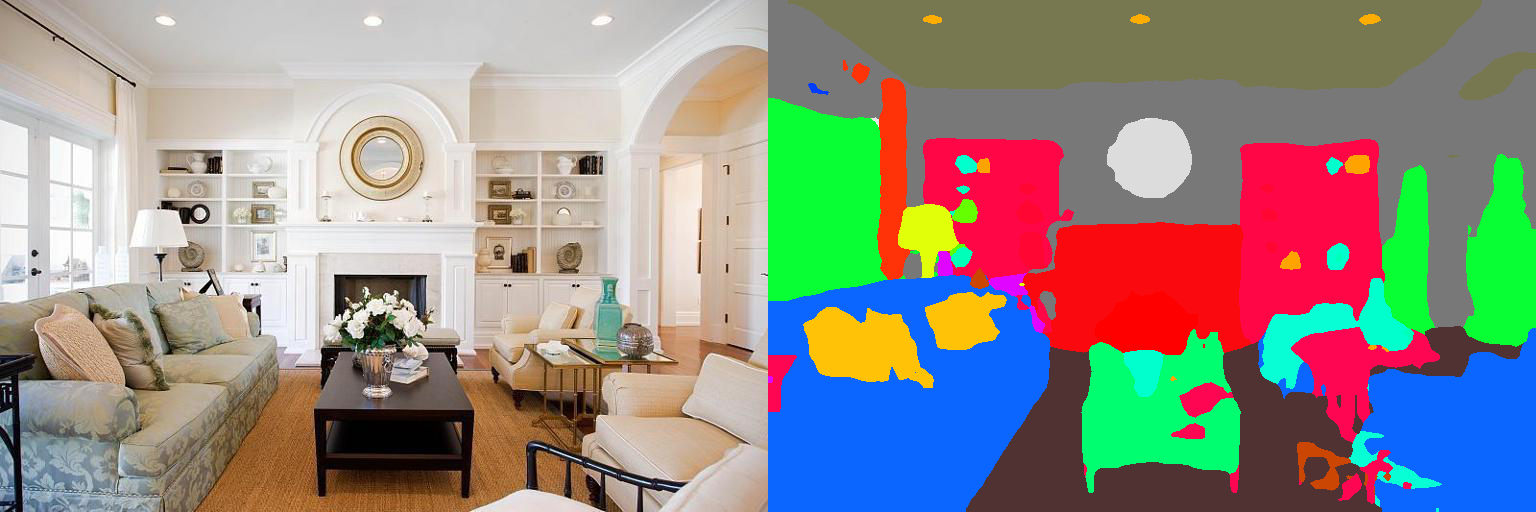

In [6]:
path = "images/source/ADE_val_00001519.jpg"
mask = smodel.predict_path(path, device=device, visualize=True)

### Configure SPADE model

Download the tar of the pretrained models from the [Google Drive Folder](https://drive.google.com/file/d/12gvlTbMvUcJewQlSEaZdeb2CdOB-b8kQ/view)

In [7]:
# !pip install gdown

# import gdown

# gdown.download(
#     url="https://drive.google.com/u/0/uc?id=12gvlTbMvUcJewQlSEaZdeb2CdOB-b8kQ", 
#     output="ckpt/spade.tar.gz"
# )

In [8]:
def generate(segm_model, source_folder: str, size=None):
    
    shutil.rmtree("images/masks/", ignore_errors=True)
    shutil.rmtree("images/result/", ignore_errors=True)
    
    for file in os.listdir(source_folder):
        
        if file.startswith("."):
            continue
        
        image_path = os.path.join(source_folder, file)
        image = Image.open(image_path)

        if size is not None:
            image = image.resize((size, size))

        print("applying segmentation...")

        mask = segm_model.predict(image, device=device, visualize=False).astype(np.uint8)
        mask = Image.fromarray(mask + 1)
        name = pathlib.Path(image_path).stem

        os.makedirs("images/masks", exist_ok=True)
        os.makedirs("images/result", exist_ok=True)
        
        # plt.imsave(f"images/masks/{name}_val_.png", mask3)
        mask.save(f"images/masks/{name}_val_.png")
        image.save(f"images/masks/{name}_val_.jpg")
    
    print("generating synthetic image...")
    cmd = "cd SPADE && python test.py --crop_size=512 --load_size=512 --checkpoints_dir=../ckpt --gpu_ids=0 --dataroot=../images/masks --dataset_mode=ade20k --name=ade20k_pretrained --results_dir=../images/result"
    os.system(cmd)

In [9]:
source_folder = "images/source"

generate(segm_model=smodel, source_folder=source_folder, size=512)

applying segmentation...
applying segmentation...
applying segmentation...
applying segmentation...
applying segmentation...
applying segmentation...
applying segmentation...
applying segmentation...
generating synthetic image...


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


----------------- Options ---------------
             aspect_ratio: 1.0                           
                batchSize: 1                             
      cache_filelist_read: False                         
     cache_filelist_write: False                         
          checkpoints_dir: ../ckpt                       	[default: ./checkpoints]
   contain_dontcare_label: True                          
                crop_size: 512                           	[default: 256]
                 dataroot: ../images/masks               	[default: ./datasets/cityscapes/]
             dataset_mode: ade20k                        	[default: coco]
          display_winsize: 256                           
                  gpu_ids: 0                             
                 how_many: inf                           
                init_type: xavier                        
            init_variance: 0.02                          
                  isTrain: False                        

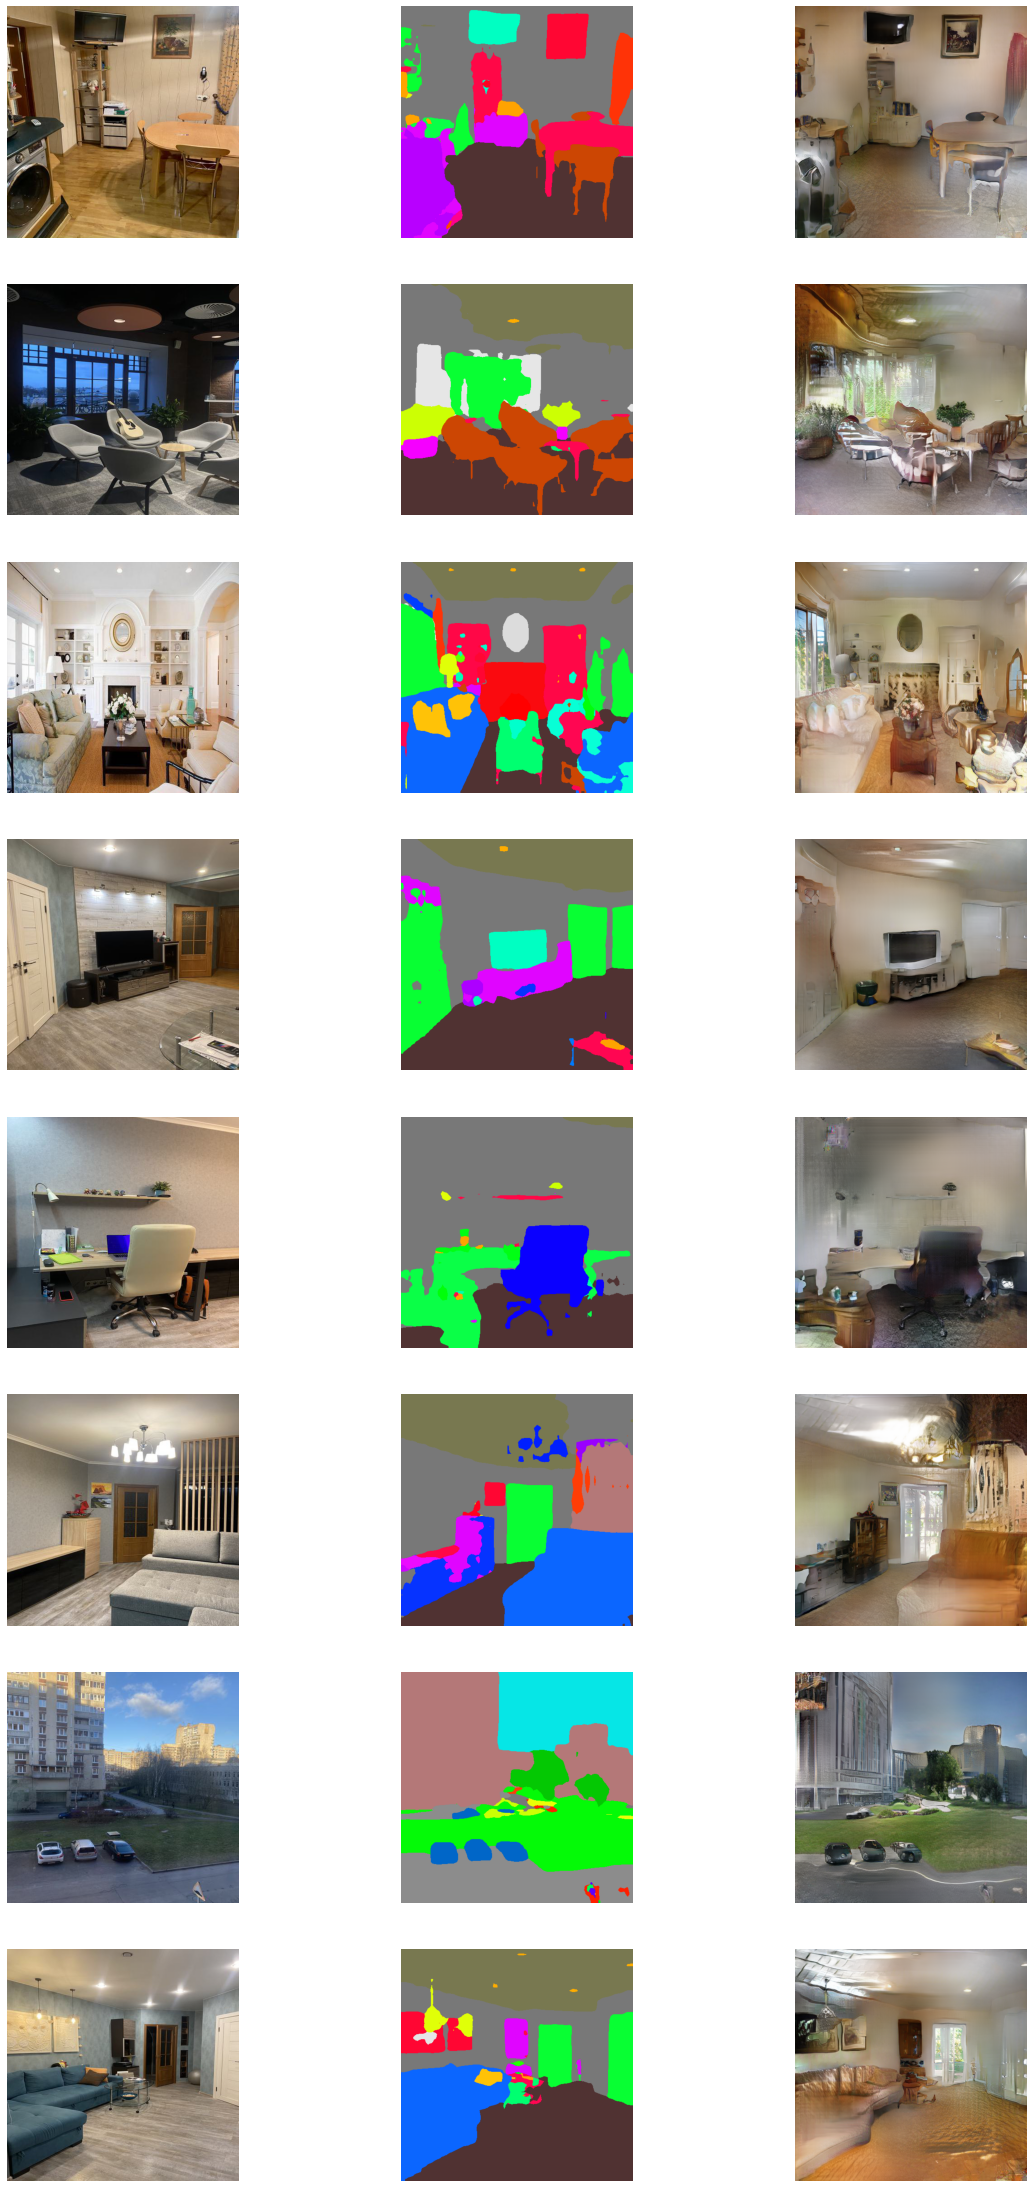

In [10]:
files = os.listdir("images/source")
files = [file for file in files if not file.startswith(".")]

_, axs = plt.subplots(len(files), 3, figsize=(20, 40), sharey="all", sharex="all")

for i, f in enumerate(files):
    name = pathlib.Path(os.path.join(source_folder, f)).stem
    orig = Image.open(f"images/masks/{name}_val_.jpg")
    mask = Image.open(f"images/masks/{name}_val_.png")
    pred = Image.open(f"images/result/ade20k_pretrained/test_latest/images/synthesized_image/{name}_val_.png")
    
    imgs = list(map(np.array, [orig, mask, pred]))
                   
    for j, (ax, im) in enumerate(zip(axs[i], imgs)):
        ax.axis("off")
        if j == 1:
            im = colorEncode(im - 1, smodel.colors).astype(np.uint8)
        ax.imshow(im)